In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots appear in the notebook
%matplotlib inline

# Load the dataset from the data/ folder
data_path = "../data/resume_data.csv" 
df = pd.read_csv(data_path)

# Inspect the first few rows
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [19]:
# Check the shape of the dataset
print("Dataset shape:", df.shape)
print("")

# Show column names and data types
df.info()
print("")

# Check basic descriptive stats (numerical columns only)
df.describe()
print("")

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

#Number of unique values in each category column
print("Unique values per column:")
print(df['Category'].nunique())
print(df['Category'].unique())

Dataset shape: (2484, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


Missing values per column:
ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64
Unique values per column:
24
['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'CHEF' 'FINANCE' 'APPAREL'
 'ENGINEERING' 'ACCOUNTANT' 'CONSTRUCTION' 'PUBLIC-RELATIONS' 'BANKING'
 'ARTS' 'AVIATION']


Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


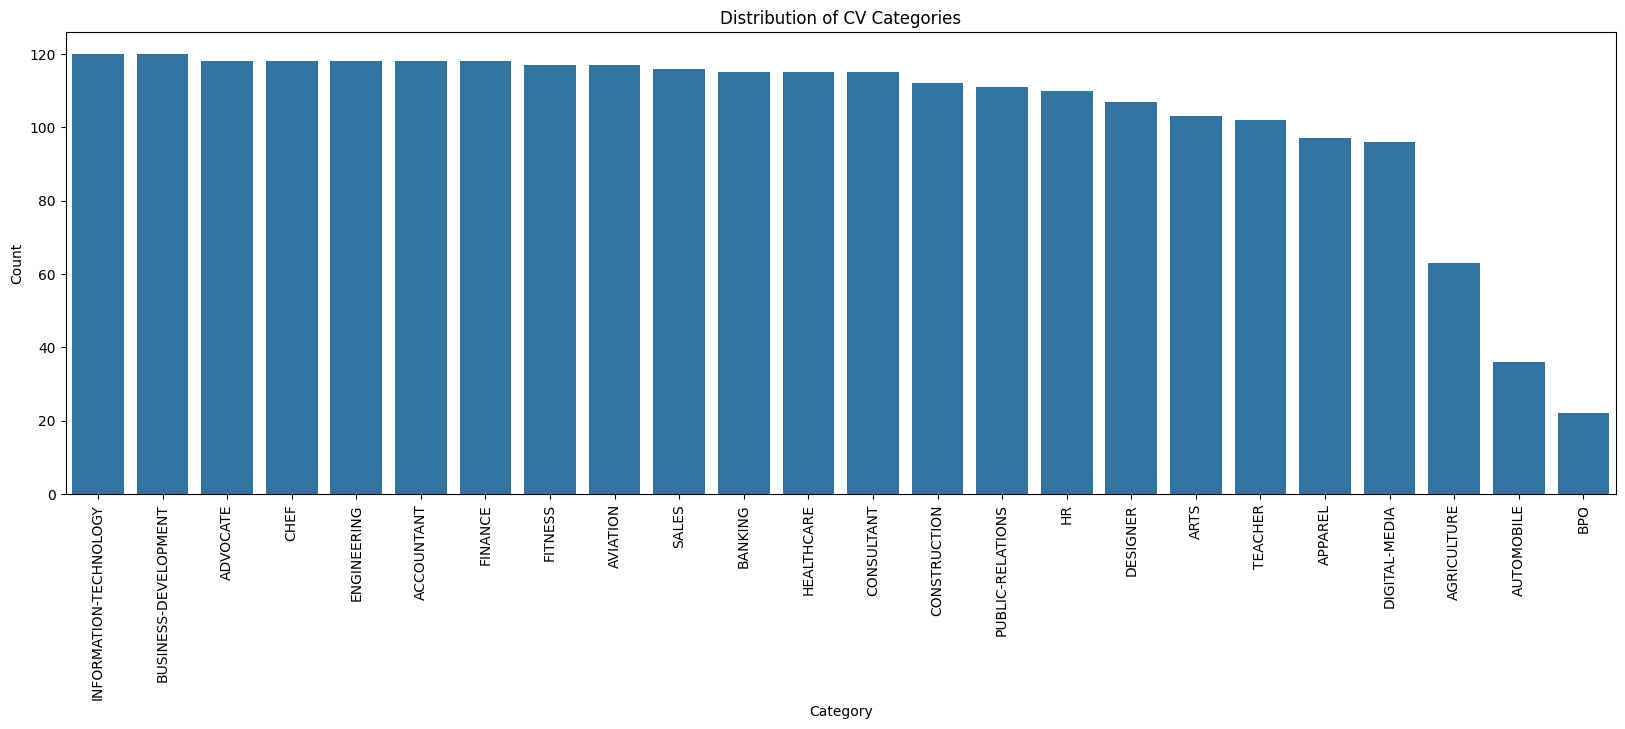

In [20]:
# Count how many resumes per category
category_counts = df["Category"].value_counts()
print(category_counts)

# Quick bar plot of category distribution
plt.figure(figsize=(20, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=90)
plt.title("Distribution of CV Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


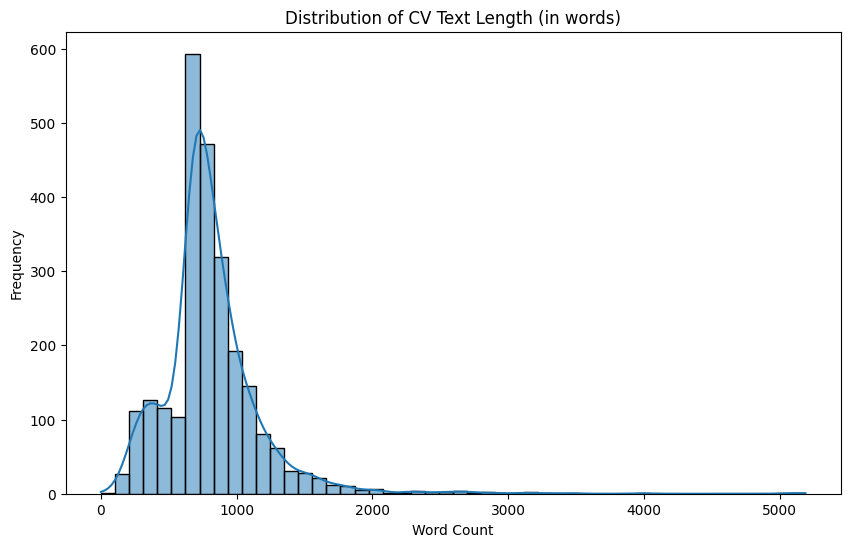

count    2484.000000
mean      811.325684
std       371.006906
min         0.000000
25%       651.000000
50%       757.000000
75%       933.000000
max      5190.000000
Name: resume_length, dtype: float64

In [21]:
# Calculate the length of each CV in terms of word count
df["resume_length"] = df["Resume_str"].apply(lambda x: len(str(x).split()))

# Plot the distribution of CV text lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="resume_length", bins=50, kde=True)
plt.title("Distribution of CV Text Length (in words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Display descriptive statistics about the CV lengths
df["resume_length"].describe()

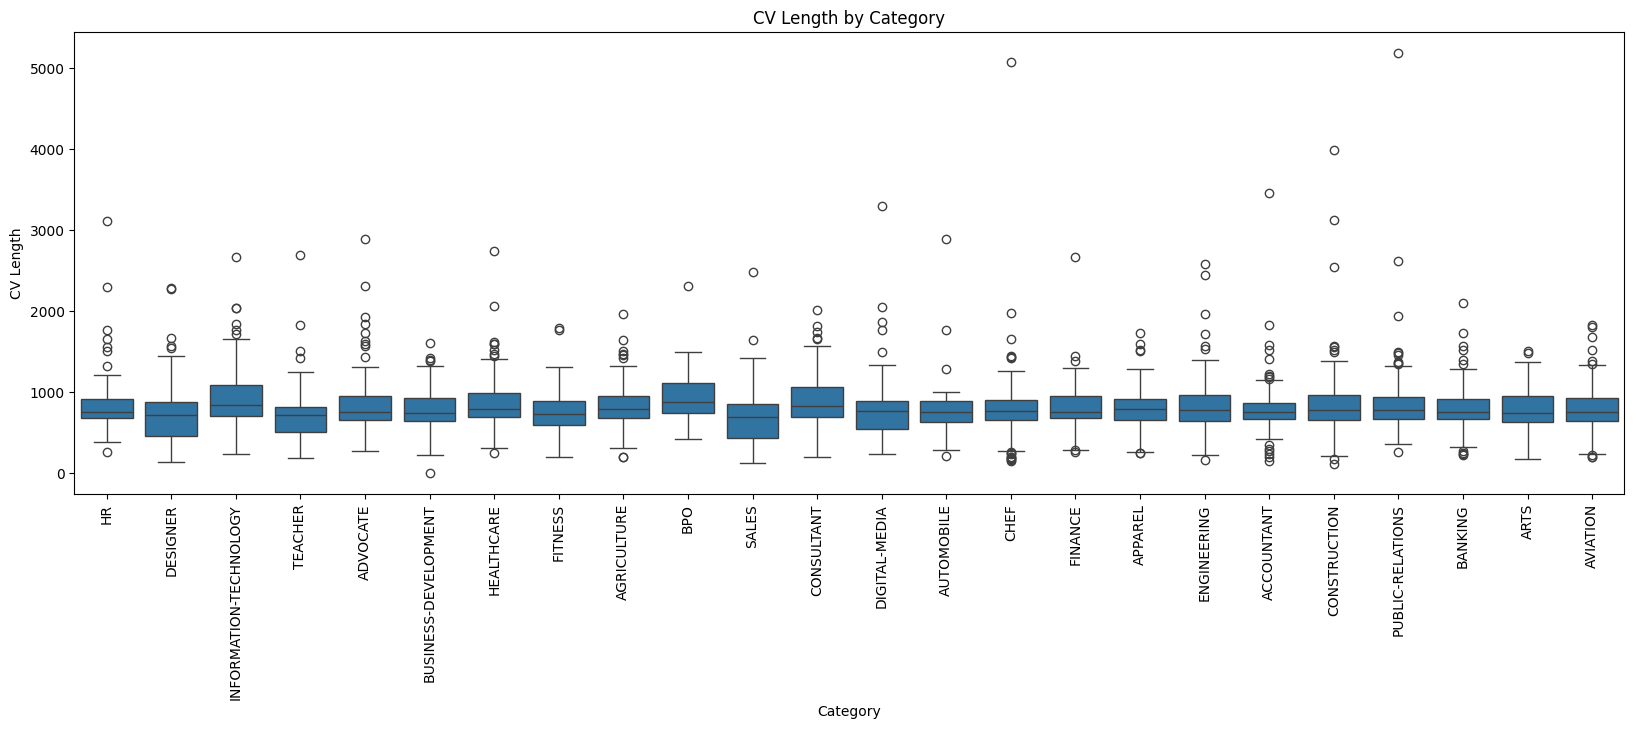

In [ ]:
# Plot a boxplot to show the distribution of CV lengths by category
plt.figure(figsize=(20, 6))
sns.boxplot(x='Category', y='resume_length', data=df)
plt.xlabel('Category')
plt.ylabel('CV Length')
plt.title('CV Length by Category')
plt.xticks(rotation=90)
plt.show()


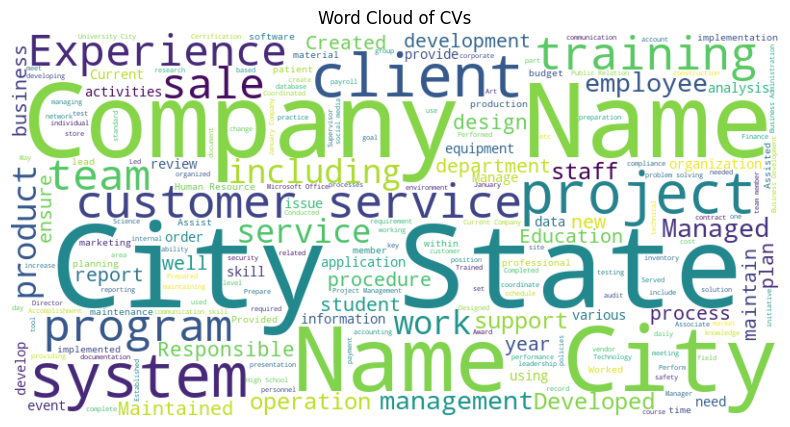

In [39]:
# Import the WordCloud module
from wordcloud import WordCloud

# Combine all cv texts into a single string
text = ' '.join(df['Resume_str'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of CVs')
plt.show()

In [54]:
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Add custom stop words (Discovered from the word cloud)
custom_stop_words = {"city", "state", "name", "company", "summary", "include"}
for word in custom_stop_words:
    nlp.Defaults.stop_words.add(word)
    nlp.vocab[word].is_stop = True

# tokenize + lemmatize text
def preprocess_text(text):
    """
    Simple example: convert to doc, remove punctuation & stop words, and lemmatize tokens.
    """
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and len(token.text.strip()) > 2]
    return " ".join(tokens)

# Apply the preprocess_text function to the entire dataframe
df["processed_resume"] = df["Resume_str"].apply(preprocess_text)

# Display the first few rows of the dataframe to verify the changes
df[["Resume_str", "processed_resume"]].head()


KeyboardInterrupt: 

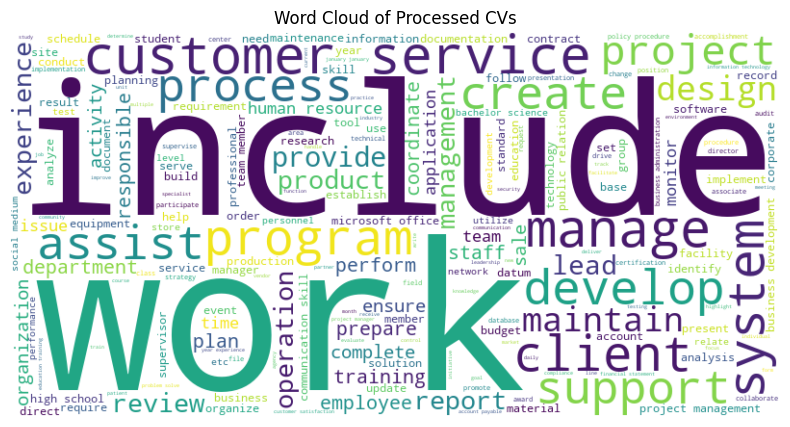

In [ ]:
# Combine all processed resume texts into a single string
processed_text = ' '.join(df['processed_resume'])

# Generate a word cloud image from the processed text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Processed CVs')
plt.show()


In [ ]:
# Get the list of stop words from spaCy
spacy_stop_words = nlp.Defaults.stop_words

# Print the stop words
print(spacy_stop_words)

{'they', 'whereupon', 'within', 'whither', '’ve', 'indeed', 'was', 'though', 'again', 'whose', 'get', "'s", 'often', 'seems', 'except', 'during', 'have', 'onto', 'the', 'off', 'i', 'anyhow', 'afterwards', 'latterly', 'thru', 'but', 'amount', 'anywhere', 'two', 'you', 'become', 'any', 'really', 'enough', 'further', 'thereafter', 'ours', '’d', 'meanwhile', 'in', 'wherever', 'at', 'since', "'d", 'out', 'both', 'how', 'under', 'mine', 'yourself', 'go', 'ever', 'these', 'beside', 'per', 'herein', 'side', 'please', 'n‘t', 'part', 'by', 'had', 'us', 'first', 'whole', 'somehow', 'if', 'hereupon', 'himself', 'up', 'therefore', 'being', 'most', 'whereby', 'other', 'unless', 'front', 'somewhere', 'for', 'nothing', 'forty', 'four', 'of', 'not', 'former', 'three', 'towards', 'none', 'too', 'each', 'became', 'next', 'otherwise', 'some', 'my', 'very', '‘d', 'themselves', 'me', 'would', 'do', '‘ve', 'put', 'made', 'been', 'more', 'just', 'say', 'namely', 'yours', 'what', 'while', 'anyway', 'our', 'the